In [1]:
import torch
import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import h5py
import seaborn as sns


# importing sys
import sys

# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/home/jessica/Documentos/Codigo_Limpio/src/old_versions')
from LSTM_module import LSTM

# Enable high-resolution plotting
%config InlineBackend.figure_format = 'retina'
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# To latex plots:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

# Loading data test set

In [2]:
# To load the file

directory = '../data/DataNew/'
name_data = 'ngrid32_delta_20250319-203507.h5'
file_path = directory + name_data

# --- Load Data ---
with h5py.File(file_path, 'r') as h5f:
    X = h5f['dataset_X'][:]
    y = h5f['dataset_y'][:]

In [3]:
# --- Inspect Shape ---
X_shape = X.shape  # e.g., (num_trajectories, num_timesteps, num_features)

# --- Assign Shape Dimensions ---
num_trajectories, num_timesteps, num_features = X_shape

# --- Infer Structure ---
num_grid_points = num_features // 3  # assuming 3 features per grid point: real, imag, potential

# --- Print Information ---
print(" Data loaded from:", name_data)
print(f" Shape of X: {X_shape}")
print(f"  • Number of trajectories or total data      : {num_trajectories}")
print(f"  • Number of time steps (fs)                 : {num_timesteps}")
print(f"  • Total features per time step: {num_features}")
print(f"    ↳ Composed of:")
print(f"      - Real part     : {num_grid_points} grid points")
print(f"      - Imag part     : {num_grid_points} grid points")
print(f"      - Potential     : {num_grid_points} grid points")


 Data loaded from: ngrid32_delta_20250319-203507.h5
 Shape of X: (50, 200, 96)
  • Number of trajectories or total data      : 50
  • Number of time steps (fs)                 : 200
  • Total features per time step: 96
    ↳ Composed of:
      - Real part     : 32 grid points
      - Imag part     : 32 grid points
      - Potential     : 32 grid points


# Loading LSTM class and trained model

In [4]:
model = LSTM(
    hidden_size=1024,
    num_layers=2,
    seq_length=num_timesteps,
    num_output=2 * num_grid_points,
    input_size=3 * num_grid_points
)

If model was saved with: `torch.save(model,'nameModel.pth')`  
⚠️ Not recommended for future projects

In [5]:
model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth', map_location='cpu')
model.eval()


/tmp/ipykernel_61872/1220633917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth', map_locati

LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)

If model was save with `torch.save(model.state_dict(), 'model_name.pth')`, uncomment next  
✅ recommended

In [6]:

# Rebuild the model architecture
#model = MyLSTMModelClass(**your_parameters)

# Load weights safely to the desired device (CPU in this case)
#model.load_state_dict(torch.load('model_name.pth', map_location=torch.device('cpu')))
#model.eval()  # Set to inference mode

# Predicting a trajectory

- We take just the initial wavefunction $\Psi(0)$ and the potential $V(t)$.
- The model is generating the whole trajectory $\Psi(t)$.

In [7]:
def generate_trajectory_psi(model, X_seq, seq_len, prediction_len):
    """
    Autoregressive generation using delta-predicting many-to-one LSTM.
    
    X_seq: (timesteps, 3*num_grid_points) full trajectory input
    seq_len: length of initial window
    prediction_len: number of steps to predict
    """
    num_grid_points = X_seq.shape[1] // 3  # assuming 3 features per grid point: real, imag, potential
    model.eval()
    generated = []


    # Initialize the sequence with the first seq_len steps
    current_seq = X_seq[:seq_len].unsqueeze(0)  # shape: (1, seq_len, 3*num_grid_points)
    generated.append(current_seq[0, -1, :2*num_grid_points])  # store the last Psi (real + imag)

    # Extract the potential from time = seq_len to seq_len + prediction_len
    V = X_seq[seq_len:seq_len + prediction_len, 2*num_grid_points:]  # shape: (prediction_len, num_grid_points)

    # Initialize hidden states
    h_0 = torch.zeros(model.num_layers, 1, model.hidden_size)
    c_0 = torch.zeros(model.num_layers, 1, model.hidden_size)

    with torch.no_grad():
        for t in range(prediction_len):
            # ⚠️ Next should be adjusted to the model's forward function  -------------
            # We carry over the last hidden state and cell state from the previous step 
            output, (h_0, c_0) = model.lstm(current_seq, (h_0, c_0))
            delta = model.fc(output[:, -1, :])  # shape: (1, 2*num_grid_points)
            # -------------------------------------------------------------------------
            
            # Last Psi (real + imag) from current sequence
            last_psi = current_seq[0, -1, :2*num_grid_points]
            next_psi = last_psi + delta.squeeze(0)  # apply delta

            # Normalize next_psi to ensure its density integrates to 1
            # ⚠️ Crucial to do this step by step to avoid blow up -----------------------
            r_n = np.linspace(-1.5,1.5,num_grid_points)*(1/0.5291775)  # angstroms to au
            next_density = next_psi[:num_grid_points]**2 + next_psi[num_grid_points:]**2
            integral = np.trapz(next_density.numpy(), r_n)
            next_psi = next_psi / integral**0.5  # Normalize to ensure integral is 1
            # ----------------------------------------------------------------------------
            
            # Potential at next step
            V_next = V[t, :]

            # Build new input vector
            new_input = torch.cat([next_psi, V_next], dim=-1).unsqueeze(0).unsqueeze(0)  # (1,1,3*num_grid_points)
            generated.append(next_psi)

            # Slide the window
            current_seq = torch.cat([current_seq[:, 1:, :], new_input], dim=1)

    generated = torch.stack(generated)  # shape: (prediction_len, 2*num_grid_points)
    return generated


In [8]:
trajectory_index = 7
seq_len = 1 # Length of the sequence used to train the model / lenght of initial window
prediction_len = 199  

X_single = torch.tensor(X[trajectory_index], dtype=torch.float32) # shape: (num_timesteps, features: 3*num_grid_points)

y_true = torch.tensor(y[trajectory_index][seq_len:], dtype=torch.float32)  # true deltas after seq_len, shape: (num_timesteps - seq_len, features: 2*num_grid_points)

generated_psi = generate_trajectory_psi(model, X_single, seq_len, prediction_len)


In [9]:
generated_psi.shape  # shape: (prediction_len, 2*num_grid_points)

torch.Size([200, 64])

Integral of |ψ(r,t)|² in [a.u.]: 1.000000


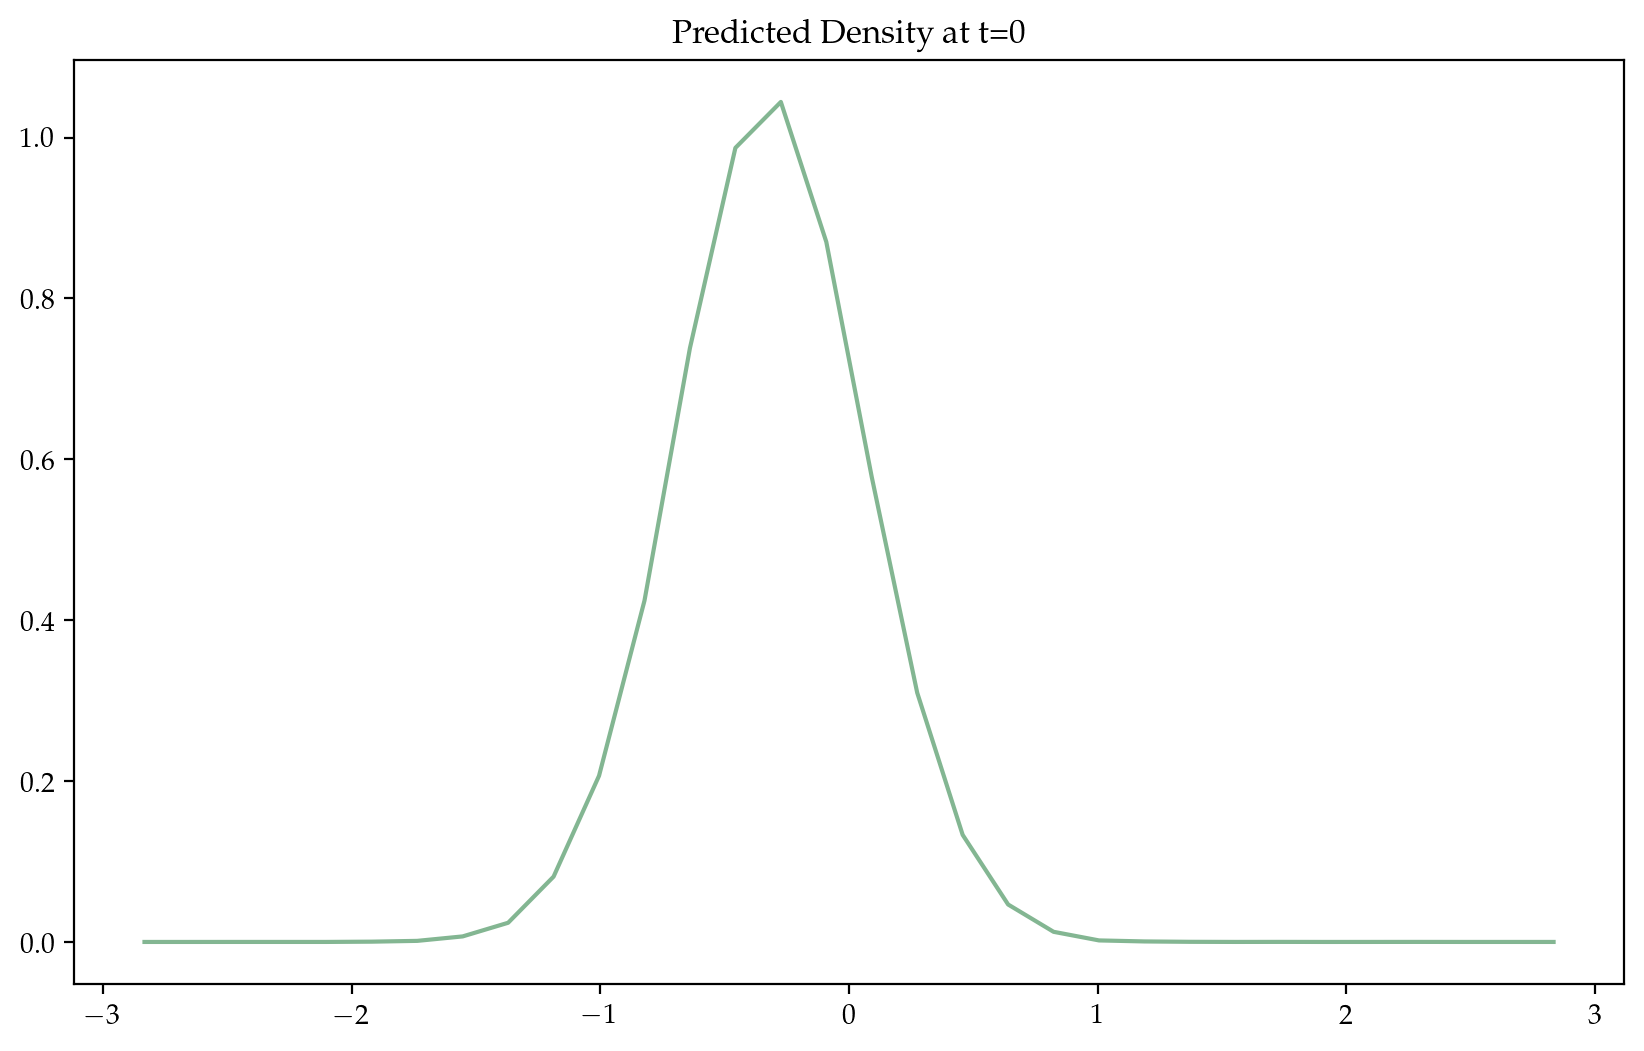

In [10]:
# Checking normalization of psi in space:
r_n = np.linspace(-1.5,1.5,num_grid_points)*(1/0.5291775)  # angstroms to au
pred_density = generated_psi[:, :num_grid_points]**2 + generated_psi[:, num_grid_points:]**2

# Plotting the predicted density
plt.figure(figsize=(10, 6))
plt.plot(r_n, pred_density[1].numpy(), label='Predicted Density', color=color[0])
plt.title('Predicted Density at t=0')
integral = np.trapz(pred_density[1], r_n)
print(f"Integral of |ψ(r,t)|² in [a.u.]: {integral:.6f}")

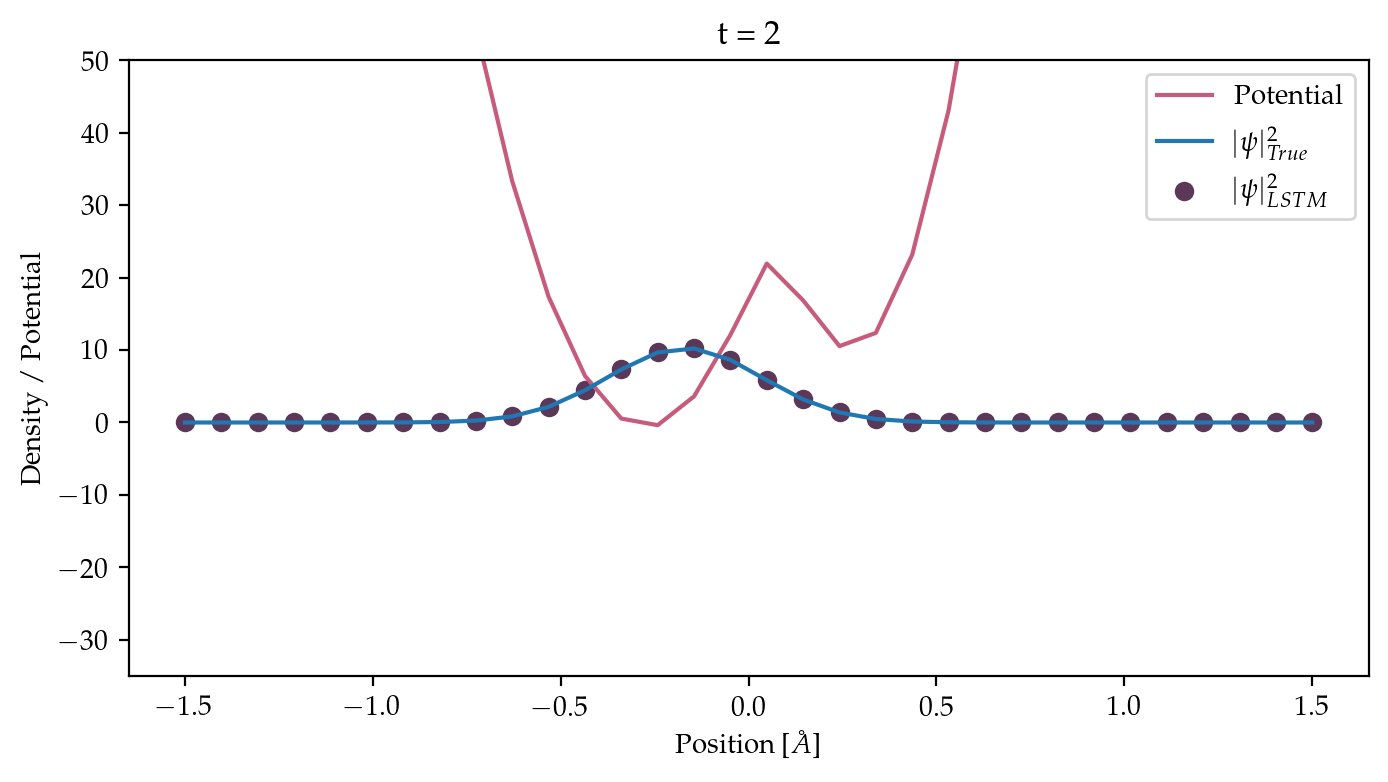

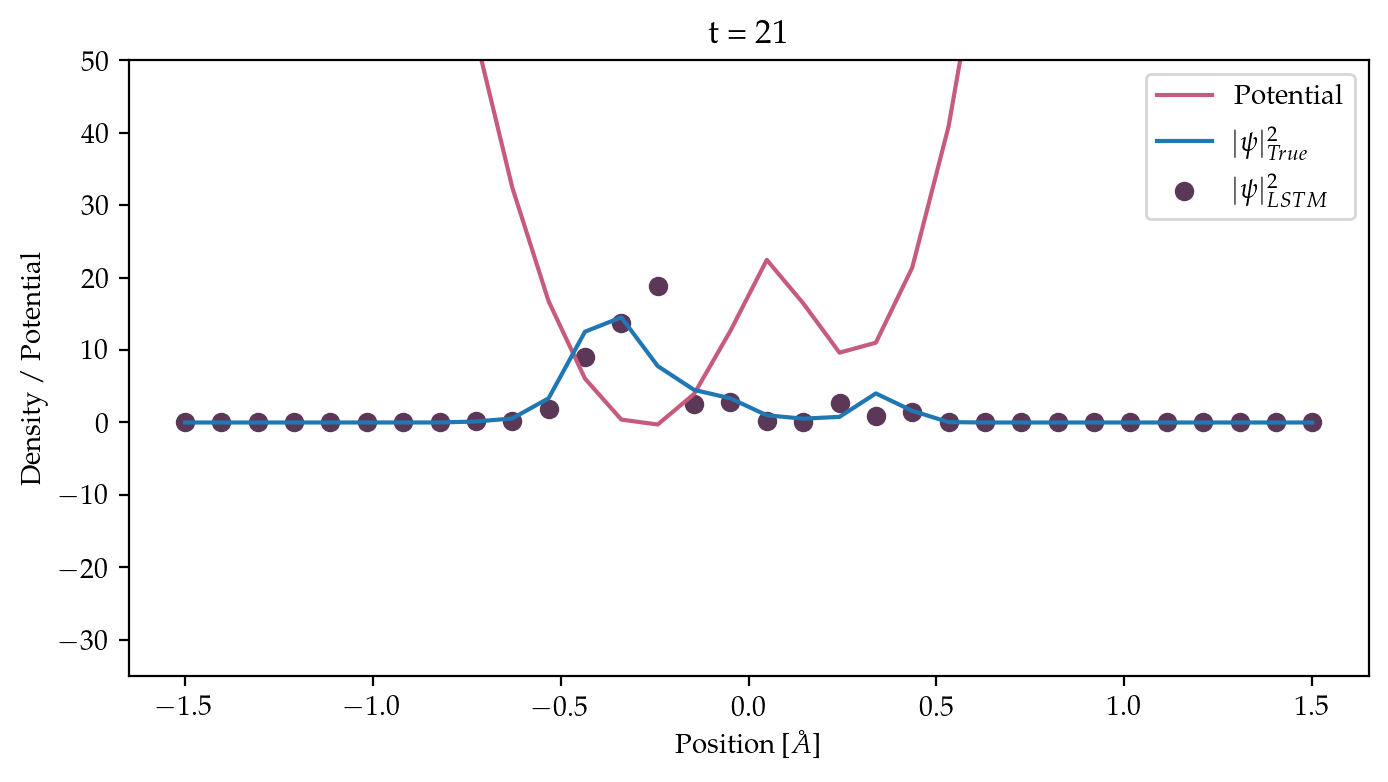

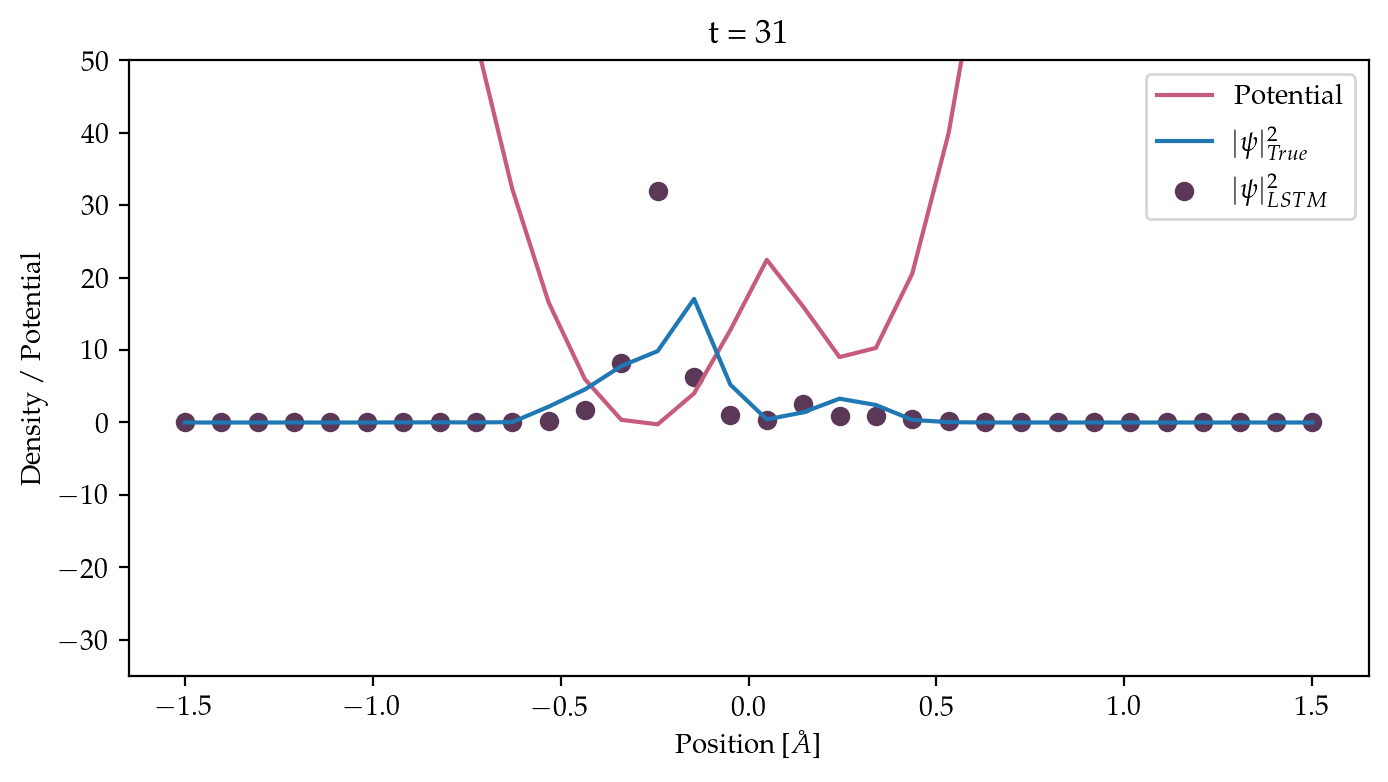

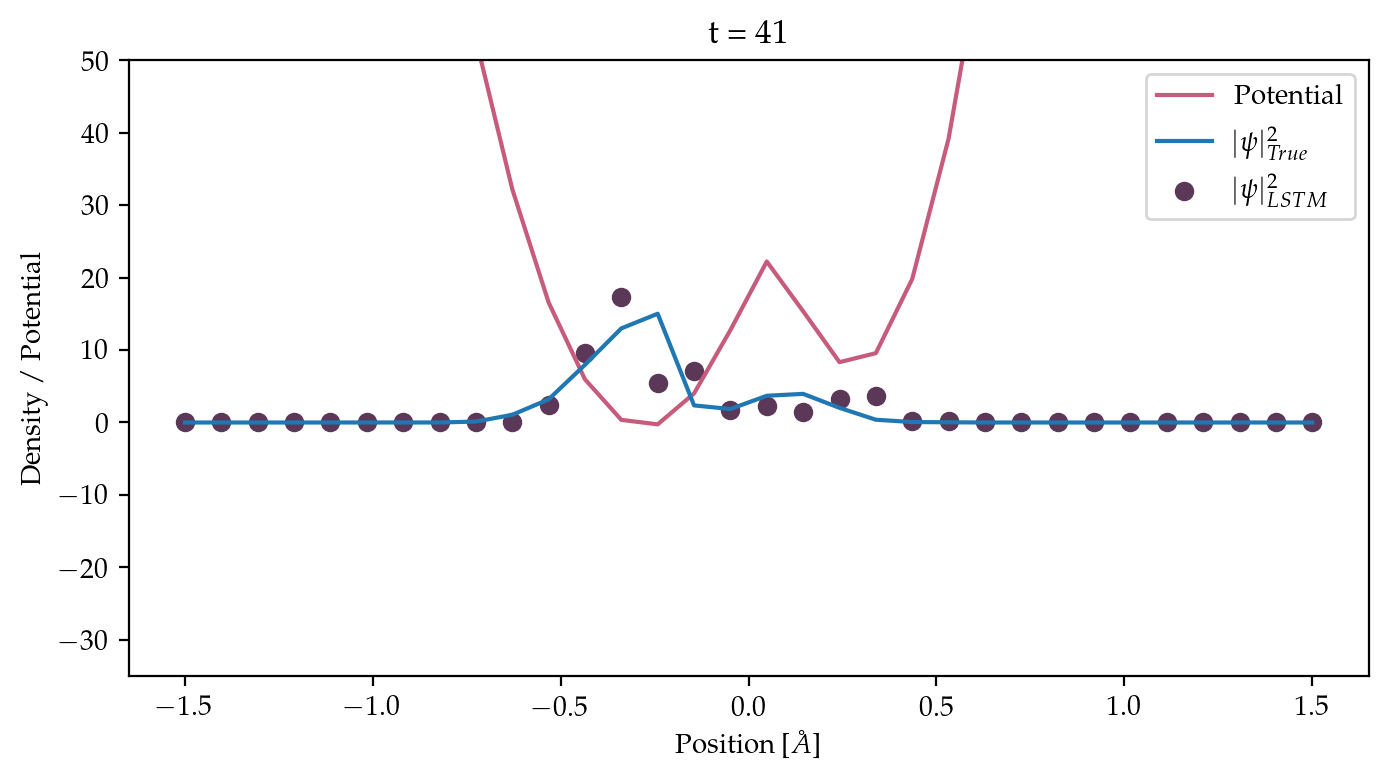

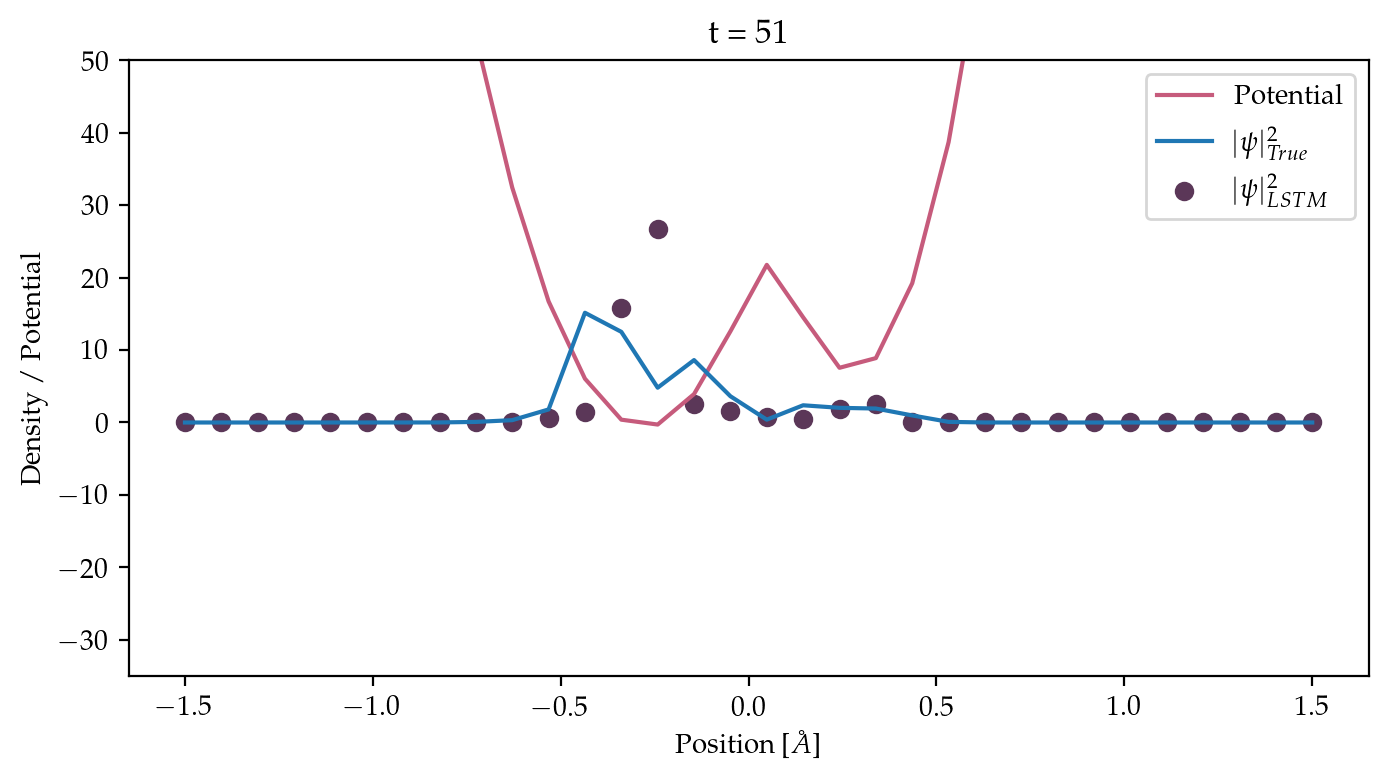

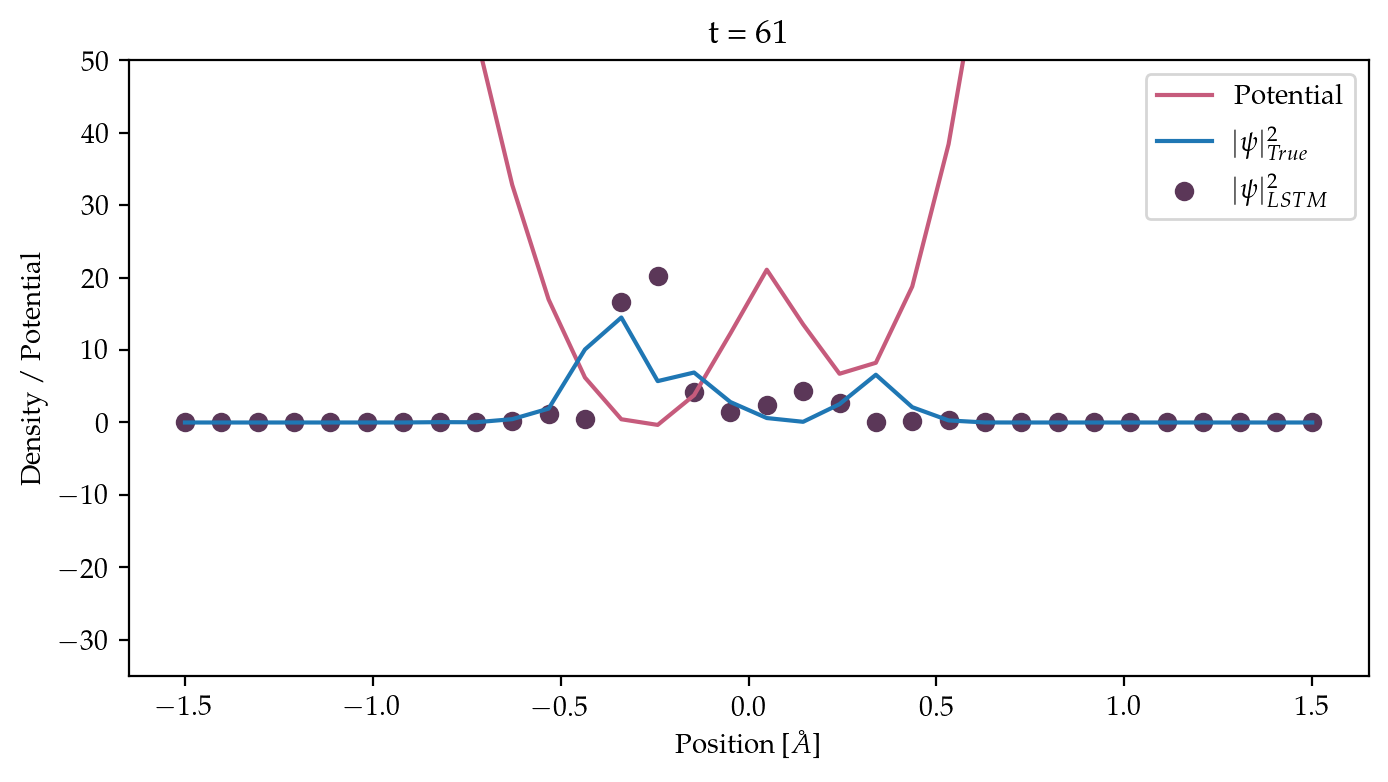

In [11]:
import matplotlib.pyplot as plt

# Selected time steps after initial sequence
steps_to_plot = [1,20,30,40,50,60]

# Last known Psi from initial sequence
Psi_start = X_single[seq_len-1, :2*num_grid_points]  # (2*num_grid_points)
V_seq = X_single[seq_len:seq_len+prediction_len, 2*num_grid_points:]       # potentials after initial seq


# Compute true density |Ψ|^2
true_psi = X_single[seq_len+1:seq_len+prediction_len, :2*num_grid_points]
true_density = true_psi[:, :num_grid_points]**2 + true_psi[:, num_grid_points:]**2

# Predicted density
pred_density = generated_psi[:, :num_grid_points]**2 + generated_psi[:, num_grid_points:]**2

# Plotting for selected steps
for t in steps_to_plot:
    plt.figure(figsize=(8,4))
    plt.plot(np.linspace(-1.5, 1.5, num_grid_points),V_seq[t-1]*(1/1.5936e-3), label="Potential", color=color[3])  # potential at that step
    plt.plot(np.linspace(-1.5, 1.5, num_grid_points),true_density[t-1]*10, label="$|\psi|^2_{True}$", color='C0')
    plt.scatter(np.linspace(-1.5, 1.5, num_grid_points), pred_density[t-1]*10, label="$|\psi|^2_{LSTM}$", color=color[4])
    plt.xlabel("Position [$\AA$]")
    plt.ylabel("Density / Potential")
    plt.ylim([-35,50])
    plt.title(f"t = {seq_len+t}")
    plt.legend()
    plt.show()


# Heat maps

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_wavefunction_heatmap(X, dat=0, grid_range=(-1.5, 1.5), n_xticks=5, 
                            n_yticks=4, save_path=None,
                            time_slice=None,
                            is_psi_pred = False,
                            is_delta=False,
                            initial_input=None):
    """
    Plots a heatmap of |psi(r, t)|^2 over space and time (optionally sliced in time).
    
    Parameters:
        X (tensor): Input tensor of shape (trajectories, timesteps, features).
                    Can be actual ψ or Δψ.
        dat (int): Trajectory index.
        grid_range (tuple): (min, max) range of spatial domain in Angstroms.
        n_xticks (int): Number of ticks on the time axis.
        n_yticks (int): Number of ticks on the position axis.
        save_path (str or None): If provided, saves the plot to this path.
        time_slice (tuple or None): Optional (start, end) indices to slice the time axis.4
        is_delta (bool): If True, assumes X contains Δψ and reconstructs ψ.
        initial_input (tensor or None): Required if is_delta=True.
                                        Should be the original input tensor to extract ψ(t=0).
    """

    num_trajectories, num_timesteps, num_features = X.shape
    num_grid_points = num_features // 2 if is_delta or is_psi_pred else num_features // 3
    time_range_fs = num_timesteps

    assert dat < num_trajectories, f"Trajectory index {dat} out of bounds!"

    # Spatial grid
    r_n = torch.linspace(grid_range[0], grid_range[1], num_grid_points)

    # Slice the time dimension if requested
    if time_slice:
        start, end = time_slice
        assert 0 <= start < end <= num_timesteps, "Invalid time_slice indices!"
        X_segment = X[dat, start:end, :]
        timesteps_to_plot = end - start
    else:
        X_segment = X[dat, :, :]
        timesteps_to_plot = num_timesteps
        start = 0  # for labels

    # Handle Δψ input: reconstruct ψ from initial ψ and deltas
    if is_delta:
        assert initial_input is not None, "initial_input is required when is_delta=True"
        psi_real = [initial_input[dat, 0, :num_grid_points]]
        psi_imag = [initial_input[dat, 0, num_grid_points:2*num_grid_points]]

        for t in range(X_segment.shape[0]):
            dpsi_real = X_segment[t, :num_grid_points]
            dpsi_imag = X_segment[t, num_grid_points:]
            psi_real.append(psi_real[-1] + dpsi_real)
            psi_imag.append(psi_imag[-1] + dpsi_imag)

        psi_real = torch.stack(psi_real[1:])  # discard initial copy
        psi_imag = torch.stack(psi_imag[1:])
    else:
        psi_real = X_segment[:, :num_grid_points]
        psi_imag = X_segment[:, num_grid_points:2*num_grid_points]

    # Compute density
    X_complex = np.vectorize(complex)(psi_real.T, psi_imag.T)
    X_dens = np.abs(X_complex)**2

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(X_dens, cbar_kws={'label': r'$|\psi(r,t)|^2$ [$1/\mathrm{\AA}$]'}, ax=ax)

    # --- X-axis (time) ---
    xtick_locs = np.linspace(0, timesteps_to_plot, n_xticks, dtype=int)
    if time_range_fs:
        total_fs = time_range_fs * (timesteps_to_plot / num_timesteps)
        xtick_labels = [f"{int(total_fs * i / (timesteps_to_plot)) + int(start * (time_range_fs / num_timesteps))}" for i in xtick_locs]
        ax.set_xlabel("Time [fs]")
    else:
        xtick_labels = [str(i + start) for i in xtick_locs]
        ax.set_xlabel("Time [steps]")
    ax.set_xticks(xtick_locs)
    ax.set_xticklabels(xtick_labels)

    # Optional vertical markers
    for t in [250, 500, 750]:
        ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

    # --- Y-axis (position) ---
    ytick_locs = np.linspace(0, num_grid_points - 1, n_yticks, dtype=int)
    ytick_labels = np.linspace(grid_range[0], grid_range[1], n_yticks)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels([f"{y:.1f}" for y in ytick_labels])
    ax.set_ylabel("Position [$\mathrm{\AA}$]")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")
    plt.show()


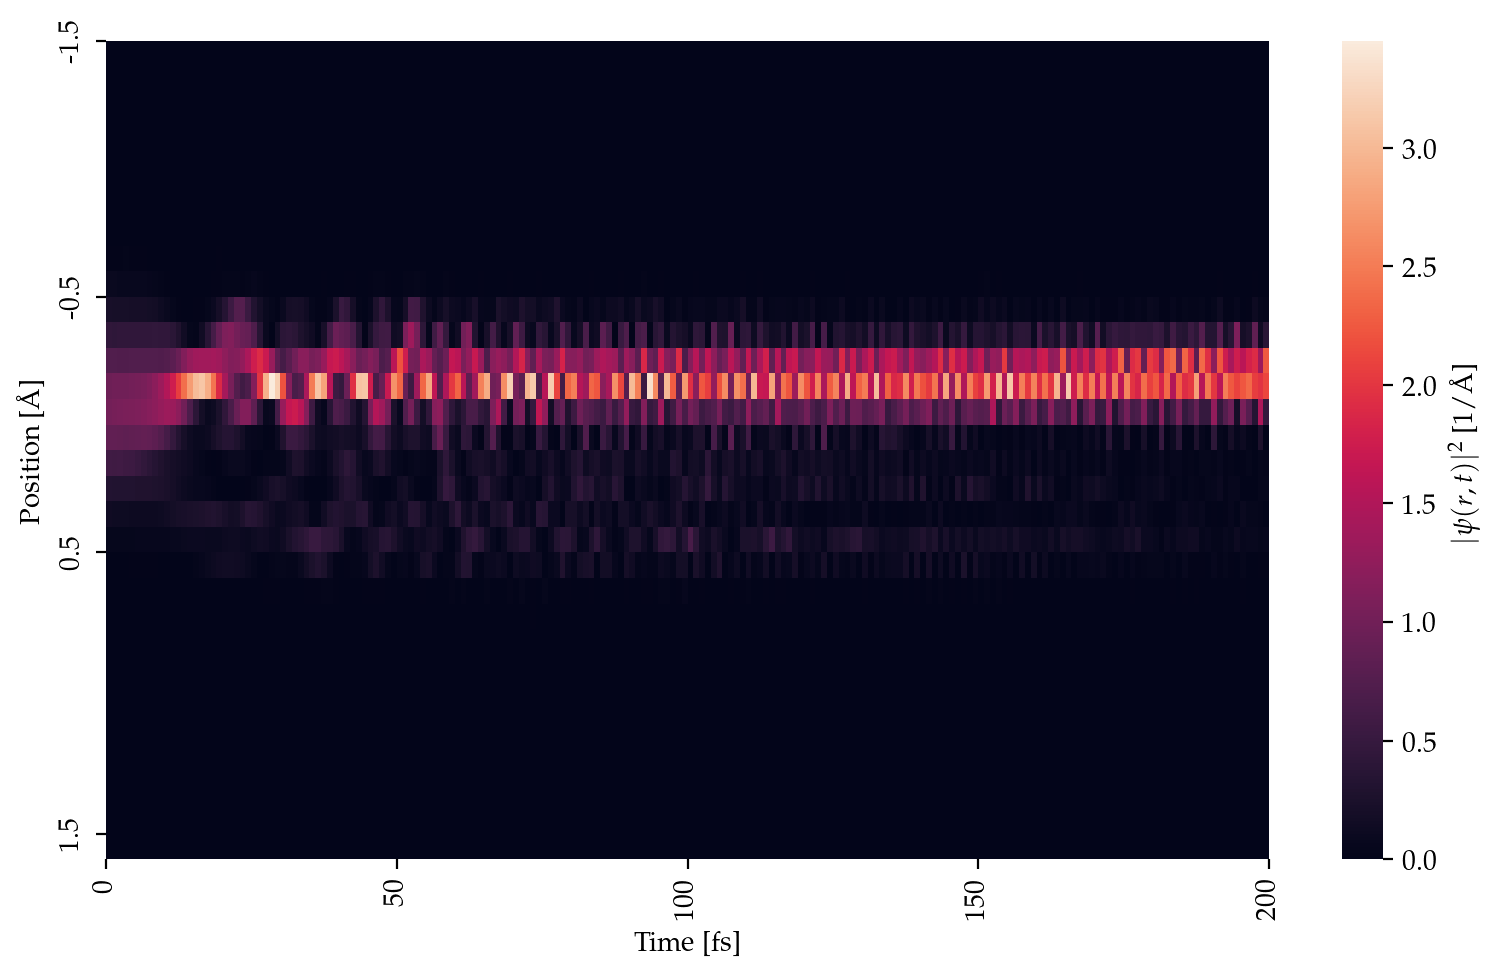

In [13]:
plot_wavefunction_heatmap(X=generated_psi.unsqueeze(0), dat=0, grid_range=(-1.5, 1.5),
                          n_xticks=5, n_yticks=4, save_path=None,
                          time_slice=None, is_delta=False, is_psi_pred=True)

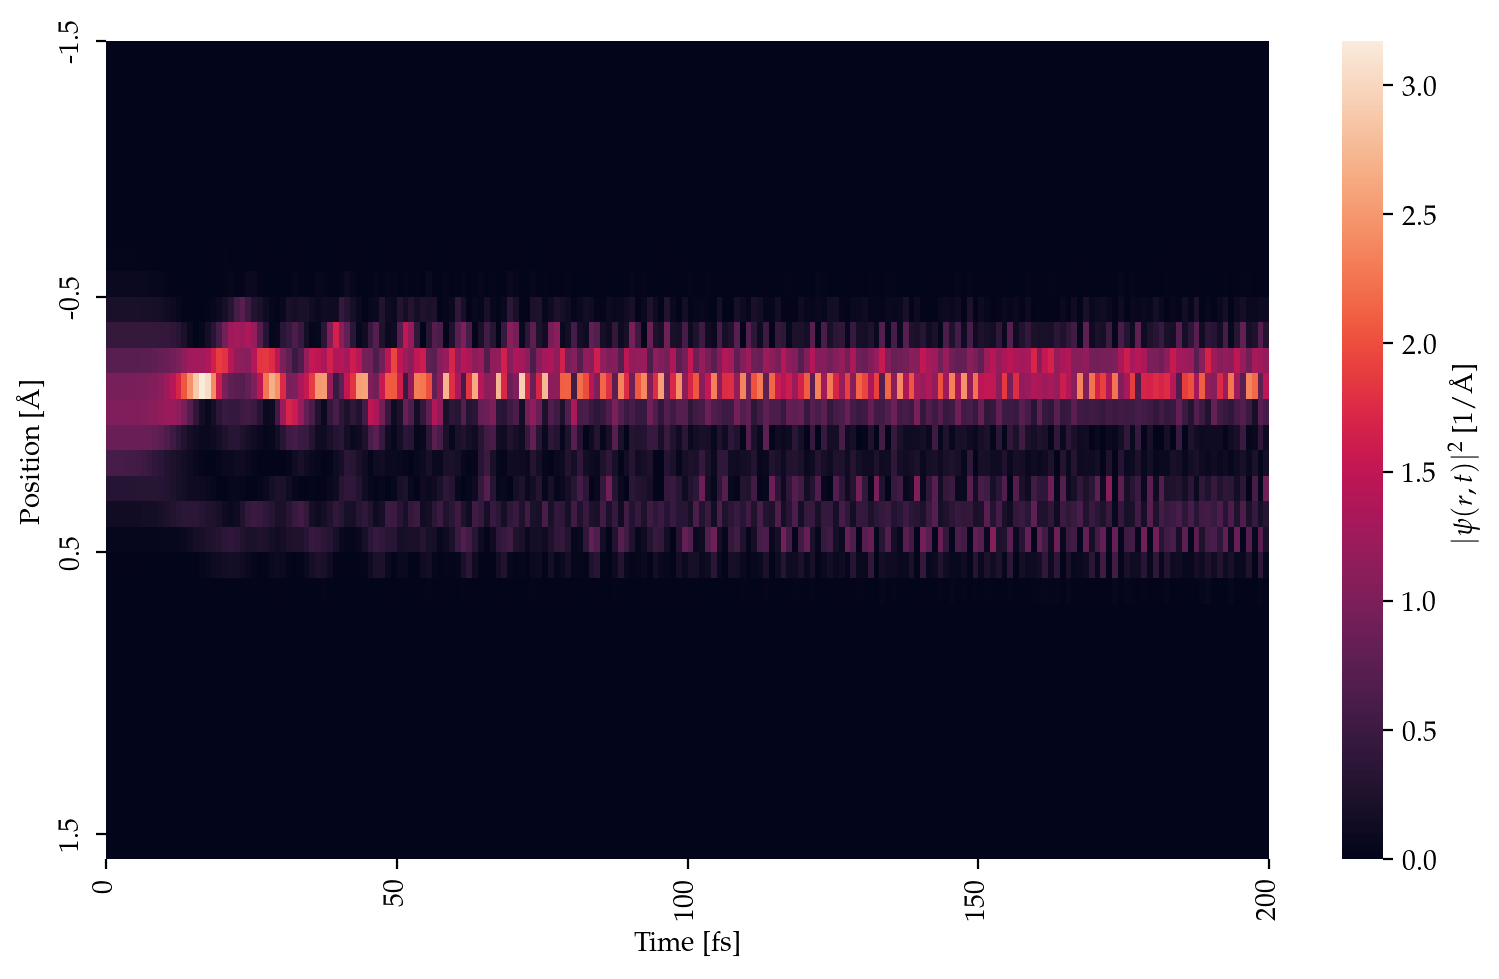

In [14]:
plot_wavefunction_heatmap(X=X_single.unsqueeze(0), dat=0, grid_range=(-1.5, 1.5),
                          n_xticks=5, n_yticks=4, save_path=None, time_slice=[0,200])

# Accuracy function
- This is calculated over a set of test / validation

In [15]:
print(f'Test dataset X shape: {X.shape}: num_trajectories={X.shape[0]}, num_timesteps={X.shape[1]}, num_features={X.shape[2]}')
print(f'Test dataset y shape: {y.shape}: num_trajectories={y.shape[0]}, num_timesteps={y.shape[1]}, num_features={y.shape[2]}')

Test dataset X shape: (50, 200, 96): num_trajectories=50, num_timesteps=200, num_features=96
Test dataset y shape: (50, 200, 64): num_trajectories=50, num_timesteps=200, num_features=64


In [16]:
all_true_psi = torch.tensor(X[:, :,:2*num_grid_points])+torch.tensor(y[:,:,:])
print(f'all_true_psi shape: {all_true_psi.shape}: num_trajectories={all_true_psi.shape[0]}, num_timesteps={all_true_psi.shape[1]}, num_features={all_true_psi.shape[2]}')

all_true_psi shape: torch.Size([50, 200, 64]): num_trajectories=50, num_timesteps=200, num_features=64


In [17]:
# Generating all trajectories
all_generated_psi = []
for i in range(num_trajectories):
    X_single = torch.tensor(X[i], dtype=torch.float32)  # shape: (num_timesteps, features: 3*num_grid_points)
    generated_psi = generate_trajectory_psi(model, X_single, seq_len, prediction_len)
    all_generated_psi.append(generated_psi)
all_generated_psi = torch.stack(all_generated_psi)  # shape: (num_trajectories, prediction_len, 2*num_grid_points)

In [18]:
all_generated_psi.shape  # shape: (num_trajectories, prediction_len, 2*num_grid_points)

torch.Size([50, 200, 64])

In [19]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article

    """

    batch_size, seq_len, n_grid = Psi_true.shape[0], Psi_true.shape[1], Psi_true.shape[2] // 2
    
    Psi_true_re = Psi_true[:,:,0:n_grid] # realpart of wavepacket 
    Psi_true_im = Psi_true[:,:,n_grid:n_grid*2] # imaginary part of wavepacket
    Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    Psi_ANN_re = Psi_ANN[:,:,0:n_grid]
    Psi_ANN_im = -(Psi_ANN[:,:,n_grid:n_grid*2])  # imaginary part of wavepacket predicted (- because conjugate)
    Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
    
    overl = Psi_A*Psi_t
    
    # Integrate over r (real integral + complex integral)
    # Trapezoid method in the grid r_n (angstroms -> au)
    
    r_n = (torch.linspace(-1.5,1.5,n_grid)*(1/0.5291775))
    overl_real = overl.real
    overl_imag = overl.imag
    
    real_integ = torch.trapz(overl_real, r_n)
    imag_integ = torch.trapz(overl_imag, r_n)
    
    # Covert to phase and magnitude of the complex result
    S =  torch.sqrt(real_integ**2 + imag_integ**2)
    angle = torch.arctan(imag_integ/real_integ)
    
    # Mean S & angle
    S = torch.sum(S)/(batch_size*seq_len)
    angle = torch.sum(angle)/(batch_size*seq_len)
    
    
    return S, angle

In [20]:
S, angle = S_overlap(all_true_psi, all_generated_psi)

In [21]:
print(f'Overlap S: {S:.6f}, angle: {angle:.6f}')

Overlap S: 0.505191, angle: -0.091705


In [120]:
print('😥')

😥
